# 🧹 Avenue Dataset Cleaner

This notebook cleans the Avenue VAD dataset by:
- **Inversion Correction** (Test dataset only): Using Scene Geometry Analysis (Method A)
- **Blur/Noise Correction** (Both datasets): Using OpenCV Fast Non-Local Means (Method 1)

**Output**: A zip file containing the cleaned dataset with the same folder structure

---

## Processing Summary

| Dataset | Inversion Check | Blur/Noise Correction |
|---------|----------------|----------------------|
| **Training** | ❌ Disabled | ✅ OpenCV Fast NLM |
| **Testing** | ✅ Method A (Scene Geometry) | ✅ OpenCV Fast NLM |


## 1. Setup and Imports


In [8]:
# Install required packages if not already installed
# !pip install opencv-python numpy tqdm

import cv2
import numpy as np
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import zipfile
from datetime import datetime

print("✅ All imports successful!")
print(f"OpenCV version: {cv2.__version__}")


✅ All imports successful!
OpenCV version: 4.12.0


## 2. Configuration

⚠️ **IMPORTANT**: Update the paths below to match your dataset location!


In [9]:
# ============================================
# CONFIGURE YOUR PATHS HERE
# ============================================

# Input dataset path (containing training_videos and testing_videos folders)
INPUT_DATASET_PATH = "/kaggle/input/avenue-dataset/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset"

# Output path for cleaned dataset
OUTPUT_DATASET_PATH = "/kaggle/working/avenue_clean"

# Output zip file name (will be created in the same directory as OUTPUT_DATASET_PATH)
OUTPUT_ZIP_NAME = "cleaned_avenue_dataset.zip"

# ============================================
# CORRECTION PARAMETERS
# ============================================

# Blur detection threshold (lower = more sensitive, higher = less frames flagged as blurry)
BLUR_THRESHOLD = 100

# Non-Local Means Denoising parameters
NLM_H = 10                    # Filter strength (higher = more denoising, may blur details)
NLM_H_COLOR = 10              # Same for color components
NLM_TEMPLATE_WINDOW = 7       # Should be odd (patch size)
NLM_SEARCH_WINDOW = 21        # Should be odd (search area)

# Inversion detection thresholds (for Scene Geometry Method A)
GREEN_RATIO_MULTIPLIER = 1.5  # Top green must be this times more than bottom to flag inversion
GREEN_MIN_RATIO = 0.05        # Minimum green ratio to consider
BROWN_RATIO_MULTIPLIER = 1.3  # Top brown must be this times more than bottom
BROWN_MIN_RATIO = 0.1         # Minimum brown ratio to consider

print("✅ Configuration loaded!")
print(f"📂 Input: {INPUT_DATASET_PATH}")
print(f"📂 Output: {OUTPUT_DATASET_PATH}")
print(f"📦 ZIP: {OUTPUT_ZIP_NAME}")


✅ Configuration loaded!
📂 Input: /kaggle/input/avenue-dataset/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset
📂 Output: /kaggle/working/avenue_clean
📦 ZIP: cleaned_avenue_dataset.zip


## 3. Dataset Cleaner Class

This class contains:
- **Method A (Scene Geometry Analysis)**: Detects inverted frames by checking if grass/ground appears at top of image
- **Method 1 (OpenCV Fast NLM)**: Denoises frames using Non-Local Means algorithm


In [10]:
class DatasetCleaner:
    """
    Handles detection and correction of image corruptions:
    - Inversion (upside-down frames) using Scene Geometry Analysis
    - Blur/Noise using OpenCV Fast Non-Local Means
    """
    
    def __init__(self, blur_threshold=100, nlm_h=10, nlm_h_color=10,
                 nlm_template_window=7, nlm_search_window=21,
                 green_ratio_mult=1.5, green_min_ratio=0.05,
                 brown_ratio_mult=1.3, brown_min_ratio=0.1):
        
        # Blur parameters
        self.blur_threshold = blur_threshold
        self.nlm_h = nlm_h
        self.nlm_h_color = nlm_h_color
        self.nlm_template_window = nlm_template_window
        self.nlm_search_window = nlm_search_window
        
        # Inversion parameters
        self.green_ratio_mult = green_ratio_mult
        self.green_min_ratio = green_min_ratio
        self.brown_ratio_mult = brown_ratio_mult
        self.brown_min_ratio = brown_min_ratio
        
        # Statistics tracking
        self.stats = {
            'total_processed': 0,
            'inverted_detected': 0,
            'blur_detected': 0,
            'inverted_corrected': 0,
            'blur_corrected': 0
        }
    
    def reset_stats(self):
        """Reset statistics counters"""
        for key in self.stats:
            self.stats[key] = 0
    
    # =========================================
    # METHOD A: Scene Geometry Analysis
    # =========================================
    def detect_inversion(self, frame):
        """
        Detect if frame is inverted using scene geometry analysis.
        
        Avenue dataset specific:
        - Ground has grass (green) at bottom edges
        - Pavement (brown/tan) dominates lower portion
        - If these appear at TOP, frame is inverted
        
        Returns:
            bool: True if frame appears to be inverted
        """
        h, w = frame.shape[:2]
        
        # Divide into horizontal strips (top 25% and bottom 25%)
        top_strip = frame[:h//4]
        bottom_strip = frame[3*h//4:]
        
        # Convert to HSV for color analysis
        top_hsv = cv2.cvtColor(top_strip, cv2.COLOR_BGR2HSV)
        bottom_hsv = cv2.cvtColor(bottom_strip, cv2.COLOR_BGR2HSV)
        
        # ---- Check 1: Green (grass) detection ----
        # Green in HSV: H=35-85, S>40, V>40
        green_lower = np.array([35, 40, 40])
        green_upper = np.array([85, 255, 255])
        
        green_mask_top = cv2.inRange(top_hsv, green_lower, green_upper)
        green_mask_bottom = cv2.inRange(bottom_hsv, green_lower, green_upper)
        
        green_ratio_top = np.sum(green_mask_top > 0) / green_mask_top.size
        green_ratio_bottom = np.sum(green_mask_bottom > 0) / green_mask_bottom.size
        
        # In normal frames: grass is at bottom
        # In inverted frames: grass appears at TOP
        if (green_ratio_top > green_ratio_bottom * self.green_ratio_mult and 
            green_ratio_top > self.green_min_ratio):
            return True
        
        # ---- Check 2: Brown/Pavement detection ----
        # Brown/tan in HSV: H=10-25, S=30-150, V=50-200
        brown_lower = np.array([10, 30, 50])
        brown_upper = np.array([25, 150, 200])
        
        brown_mask_top = cv2.inRange(top_hsv, brown_lower, brown_upper)
        brown_mask_bottom = cv2.inRange(bottom_hsv, brown_lower, brown_upper)
        
        brown_ratio_top = np.sum(brown_mask_top > 0) / brown_mask_top.size
        brown_ratio_bottom = np.sum(brown_mask_bottom > 0) / brown_mask_bottom.size
        
        # Pavement should dominate bottom in normal frames
        if (brown_ratio_top > brown_ratio_bottom * self.brown_ratio_mult and 
            brown_ratio_top > self.brown_min_ratio):
            return True
        
        return False
    
    def correct_inversion(self, frame):
        """
        Correct inverted frame by flipping vertically.
        
        Returns:
            np.ndarray: Corrected frame
        """
        return cv2.flip(frame, 0)  # 0 = vertical flip
    
    # =========================================
    # METHOD 1: OpenCV Fast Non-Local Means
    # =========================================
    def detect_blur(self, frame):
        """
        Detect if frame is blurry using Laplacian variance.
        
        Lower variance = more blur (less sharp edges)
        
        Returns:
            tuple: (is_blurry: bool, laplacian_variance: float)
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        variance = laplacian.var()
        
        is_blurry = variance < self.blur_threshold
        return is_blurry, variance
    
    def denoise_nlm(self, frame):
        """
        Apply Non-Local Means denoising to frame.
        
        This method finds similar patches across the image and averages them,
        providing excellent noise removal while preserving edges.
        
        Returns:
            np.ndarray: Denoised frame
        """
        denoised = cv2.fastNlMeansDenoisingColored(
            frame,
            None,
            h=self.nlm_h,
            hForColorComponents=self.nlm_h_color,
            templateWindowSize=self.nlm_template_window,
            searchWindowSize=self.nlm_search_window
        )
        return denoised
    
    # =========================================
    # Main Processing Functions
    # =========================================
    def process_train_frame(self, frame):
        """
        Process a training frame:
        - NO inversion check (training data is clean)
        - Apply blur/noise correction
        
        Returns:
            tuple: (processed_frame, corrections_applied: dict)
        """
        corrections = {'inverted': False, 'denoised': False}
        processed = frame.copy()
        
        # Check and correct blur/noise
        is_blurry, variance = self.detect_blur(processed)
        if is_blurry:
            processed = self.denoise_nlm(processed)
            corrections['denoised'] = True
            self.stats['blur_detected'] += 1
            self.stats['blur_corrected'] += 1
        
        self.stats['total_processed'] += 1
        return processed, corrections
    
    def process_test_frame(self, frame):
        """
        Process a test frame:
        - Apply inversion check and correction
        - Apply blur/noise correction
        
        Returns:
            tuple: (processed_frame, corrections_applied: dict)
        """
        corrections = {'inverted': False, 'denoised': False}
        processed = frame.copy()
        
        # Check and correct inversion FIRST
        if self.detect_inversion(processed):
            processed = self.correct_inversion(processed)
            corrections['inverted'] = True
            self.stats['inverted_detected'] += 1
            self.stats['inverted_corrected'] += 1
        
        # Check and correct blur/noise
        is_blurry, variance = self.detect_blur(processed)
        if is_blurry:
            processed = self.denoise_nlm(processed)
            corrections['denoised'] = True
            self.stats['blur_detected'] += 1
            self.stats['blur_corrected'] += 1
        
        self.stats['total_processed'] += 1
        return processed, corrections


# Initialize cleaner with configured parameters
cleaner = DatasetCleaner(
    blur_threshold=BLUR_THRESHOLD,
    nlm_h=NLM_H,
    nlm_h_color=NLM_H_COLOR,
    nlm_template_window=NLM_TEMPLATE_WINDOW,
    nlm_search_window=NLM_SEARCH_WINDOW,
    green_ratio_mult=GREEN_RATIO_MULTIPLIER,
    green_min_ratio=GREEN_MIN_RATIO,
    brown_ratio_mult=BROWN_RATIO_MULTIPLIER,
    brown_min_ratio=BROWN_MIN_RATIO
)

print("✅ DatasetCleaner initialized!")


✅ DatasetCleaner initialized!


## 4. Helper Functions for Dataset Processing


In [11]:
def get_all_frame_paths(dataset_path, folder_name):
    """
    Get all frame paths from a dataset folder.
    
    Args:
        dataset_path: Root path of dataset
        folder_name: 'training_videos' or 'testing_videos'
    
    Returns:
        list: List of tuples (clip_folder, frame_path)
    """
    folder_path = Path(dataset_path) / folder_name
    frame_paths = []
    
    if not folder_path.exists():
        print(f"⚠️ Warning: {folder_path} does not exist!")
        return frame_paths
    
    # Iterate through clip folders (01, 02, ...)
    for clip_folder in sorted(folder_path.iterdir()):
        if clip_folder.is_dir():
            # Get all image files in clip folder
            for frame_file in sorted(clip_folder.iterdir()):
                if frame_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    frame_paths.append((clip_folder.name, frame_file))
    
    return frame_paths


def validate_dataset(dataset_path):
    """
    Validate that the input dataset has the expected structure.
    """
    path = Path(dataset_path)
    
    if not path.exists():
        print(f"❌ Dataset path does not exist: {dataset_path}")
        return False
    
    training_path = path / 'training_videos'
    testing_path = path / 'testing_videos'
    
    print(f"\n📁 Dataset Structure Validation")
    print(f"{'='*50}")
    print(f"Root: {dataset_path}")
    
    valid = True
    
    # Check training folder
    if training_path.exists():
        train_clips = [d for d in training_path.iterdir() if d.is_dir()]
        train_frames = get_all_frame_paths(dataset_path, 'training_videos')
        print(f"✅ training_videos: {len(train_clips)} clips, {len(train_frames)} frames")
    else:
        print(f"❌ training_videos: NOT FOUND")
        valid = False
    
    # Check testing folder
    if testing_path.exists():
        test_clips = [d for d in testing_path.iterdir() if d.is_dir()]
        test_frames = get_all_frame_paths(dataset_path, 'testing_videos')
        print(f"✅ testing_videos: {len(test_clips)} clips, {len(test_frames)} frames")
    else:
        print(f"❌ testing_videos: NOT FOUND")
        valid = False
    
    print(f"{'='*50}")
    if valid:
        print(f"✅ Dataset structure is valid!")
    else:
        print(f"❌ Dataset structure is INVALID. Please check paths.")
    
    return valid


print("✅ Helper functions defined!")


✅ Helper functions defined!


## 5. Main Processing Function


In [12]:
def process_dataset(input_path, output_path, cleaner, is_test=False):
    """
    Process an entire dataset folder (training or testing).
    
    Args:
        input_path: Path to input dataset folder
        output_path: Path to output dataset folder
        cleaner: DatasetCleaner instance
        is_test: If True, applies inversion correction
    
    Returns:
        dict: Processing statistics per clip
    """
    folder_name = 'testing_videos' if is_test else 'training_videos'
    frame_paths = get_all_frame_paths(input_path, folder_name)
    
    if not frame_paths:
        print(f"❌ No frames found in {folder_name}!")
        return {}
    
    print(f"\n{'='*50}")
    print(f"🔄 Processing: {folder_name}")
    print(f"📊 Total frames: {len(frame_paths)}")
    print(f"🔃 Inversion check: {'✅ ENABLED' if is_test else '❌ DISABLED'}")
    print(f"🔇 Blur correction: ✅ ENABLED")
    print(f"{'='*50}")
    
    # Create output directory structure
    output_folder = Path(output_path) / folder_name
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Track corrections per clip
    clip_stats = {}
    
    # Process each frame with progress bar
    for clip_name, frame_path in tqdm(frame_paths, desc=f"Cleaning {folder_name}"):
        # Create clip output folder
        clip_output = output_folder / clip_name
        clip_output.mkdir(exist_ok=True)
        
        # Read frame
        frame = cv2.imread(str(frame_path))
        if frame is None:
            print(f"\n⚠️ Could not read: {frame_path}")
            continue
        
        # Process frame based on dataset type
        if is_test:
            processed, corrections = cleaner.process_test_frame(frame)
        else:
            processed, corrections = cleaner.process_train_frame(frame)
        
        # Save processed frame
        output_frame_path = clip_output / frame_path.name
        cv2.imwrite(str(output_frame_path), processed)
        
        # Track stats per clip
        if clip_name not in clip_stats:
            clip_stats[clip_name] = {'inverted': 0, 'denoised': 0, 'total': 0}
        clip_stats[clip_name]['total'] += 1
        if corrections['inverted']:
            clip_stats[clip_name]['inverted'] += 1
        if corrections['denoised']:
            clip_stats[clip_name]['denoised'] += 1
    
    return clip_stats


print("✅ Processing function defined!")


✅ Processing function defined!


## 6. Validate Input Dataset

Run this cell to verify your dataset structure before processing.


In [13]:
# Validate the input dataset structure
is_valid = validate_dataset(INPUT_DATASET_PATH)

if not is_valid:
    print("\n⚠️ Please update INPUT_DATASET_PATH in the Configuration cell and run again.")



📁 Dataset Structure Validation
Root: /kaggle/input/avenue-dataset/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset
✅ training_videos: 16 clips, 9204 frames
✅ testing_videos: 21 clips, 11706 frames
✅ Dataset structure is valid!


## 7. 🚀 Run Dataset Cleaning

This cell processes both training and testing datasets:
- **Training**: Blur/noise correction only
- **Testing**: Inversion correction + Blur/noise correction


In [14]:
# Only proceed if dataset is valid
if not is_valid:
    print("❌ Cannot proceed - dataset validation failed.")
    print("Please fix the INPUT_DATASET_PATH and run validation again.")
else:
    # Create output directory
    output_path = Path(OUTPUT_DATASET_PATH)
    if output_path.exists():
        print(f"⚠️ Output directory already exists. Removing...")
        shutil.rmtree(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"\n📂 Output will be saved to: {OUTPUT_DATASET_PATH}")
    print(f"\n🚀 Starting dataset cleaning...\n")
    
    # ========================================
    # PROCESS TRAINING DATASET
    # ========================================
    # Reset statistics
    cleaner.reset_stats()
    
    # Process training (NO inversion check)
    train_stats = process_dataset(
        INPUT_DATASET_PATH, 
        OUTPUT_DATASET_PATH, 
        cleaner, 
        is_test=False  # Training - no inversion check
    )
    train_overall = cleaner.stats.copy()
    
    # ========================================
    # PROCESS TESTING DATASET
    # ========================================
    # Reset for test
    cleaner.reset_stats()
    
    # Process testing (WITH inversion check)
    test_stats = process_dataset(
        INPUT_DATASET_PATH, 
        OUTPUT_DATASET_PATH, 
        cleaner, 
        is_test=True  # Testing - WITH inversion check
    )
    test_overall = cleaner.stats.copy()
    
    print("\n" + "="*50)
    print("✅ Dataset cleaning complete!")
    print("="*50)



📂 Output will be saved to: /kaggle/working/avenue_clean

🚀 Starting dataset cleaning...


🔄 Processing: training_videos
📊 Total frames: 9204
🔃 Inversion check: ❌ DISABLED
🔇 Blur correction: ✅ ENABLED


Cleaning training_videos: 100%|██████████| 9204/9204 [02:42<00:00, 56.74it/s]



🔄 Processing: testing_videos
📊 Total frames: 11706
🔃 Inversion check: ✅ ENABLED
🔇 Blur correction: ✅ ENABLED


Cleaning testing_videos: 100%|██████████| 11706/11706 [03:54<00:00, 50.00it/s]


✅ Dataset cleaning complete!


## 8. 📊 View Cleaning Statistics


In [15]:
def print_statistics(train_stats, test_stats, train_overall, test_overall):
    """
    Print comprehensive cleaning statistics.
    """
    print("\n" + "="*60)
    print("📊 CLEANING STATISTICS REPORT")
    print("="*60)
    
    # Training stats
    print("\n📁 TRAINING DATASET")
    print("-"*40)
    print(f"  Total frames processed:     {train_overall['total_processed']}")
    print(f"  Inversion check:            DISABLED (not needed for training)")
    print(f"  Blurry frames corrected:    {train_overall['blur_corrected']}")
    if train_overall['total_processed'] > 0:
        blur_pct = (train_overall['blur_corrected'] / train_overall['total_processed']) * 100
        print(f"  Blur correction rate:       {blur_pct:.2f}%")
    
    # Testing stats
    print("\n📁 TESTING DATASET")
    print("-"*40)
    print(f"  Total frames processed:     {test_overall['total_processed']}")
    print(f"  Inverted frames corrected:  {test_overall['inverted_corrected']}")
    print(f"  Blurry frames corrected:    {test_overall['blur_corrected']}")
    if test_overall['total_processed'] > 0:
        inv_pct = (test_overall['inverted_corrected'] / test_overall['total_processed']) * 100
        blur_pct = (test_overall['blur_corrected'] / test_overall['total_processed']) * 100
        print(f"  Inversion correction rate:  {inv_pct:.2f}%")
        print(f"  Blur correction rate:       {blur_pct:.2f}%")
    
    # Per-clip breakdown for test (show clips with corrections)
    print("\n📋 TEST CLIPS WITH CORRECTIONS")
    print("-"*40)
    clips_with_issues = {k: v for k, v in test_stats.items() 
                         if v['inverted'] > 0 or v['denoised'] > 0}
    
    if clips_with_issues:
        print(f"  {'Clip':<10} {'Inverted':<12} {'Denoised':<12} {'Total':<10}")
        print("  " + "-"*44)
        for clip, stats in sorted(clips_with_issues.items()):
            print(f"  {clip:<10} {stats['inverted']:<12} {stats['denoised']:<12} {stats['total']:<10}")
    else:
        print("  No test clips required corrections!")
    
    # Per-clip breakdown for train (show clips with blur)
    print("\n📋 TRAIN CLIPS WITH BLUR CORRECTIONS")
    print("-"*40)
    train_clips_blur = {k: v for k, v in train_stats.items() if v['denoised'] > 0}
    
    if train_clips_blur:
        print(f"  {'Clip':<10} {'Denoised':<12} {'Total':<10}")
        print("  " + "-"*32)
        for clip, stats in sorted(train_clips_blur.items()):
            print(f"  {clip:<10} {stats['denoised']:<12} {stats['total']:<10}")
    else:
        print("  No train clips required blur corrections!")
    
    print("\n" + "="*60)


# Print statistics if processing was completed
if 'train_stats' in dir() and 'test_stats' in dir():
    print_statistics(train_stats, test_stats, train_overall, test_overall)
else:
    print("⚠️ No statistics available. Please run the processing cell first.")



📊 CLEANING STATISTICS REPORT

📁 TRAINING DATASET
----------------------------------------
  Total frames processed:     9204
  Inversion check:            DISABLED (not needed for training)
  Blurry frames corrected:    0
  Blur correction rate:       0.00%

📁 TESTING DATASET
----------------------------------------
  Total frames processed:     11706
  Inverted frames corrected:  3538
  Blurry frames corrected:    0
  Inversion correction rate:  30.22%
  Blur correction rate:       0.00%

📋 TEST CLIPS WITH CORRECTIONS
----------------------------------------
  Clip       Inverted     Denoised     Total     
  --------------------------------------------
  01         147          0            499       
  02         350          0            1211      
  03         220          0            737       
  04         302          0            947       
  05         307          0            1007      
  06         188          0            627       
  07         186          0         

## 9. 📦 Create ZIP Archive

This cell creates a compressed ZIP file of the cleaned dataset.


In [16]:
def create_zip_archive(source_folder, zip_name):
    """
    Create a ZIP archive of the cleaned dataset.
    
    Args:
        source_folder: Path to the cleaned dataset folder
        zip_name: Name of the output zip file
    
    Returns:
        str: Path to the created zip file
    """
    source_path = Path(source_folder)
    zip_path = source_path.parent / zip_name
    
    print(f"\n📦 Creating ZIP archive...")
    print(f"   Source: {source_folder}")
    print(f"   Output: {zip_path}")
    
    # Count total files for progress
    all_files = list(source_path.rglob('*'))
    files_only = [f for f in all_files if f.is_file()]
    
    print(f"   Total files to archive: {len(files_only)}")
    
    # Create zip file with compression
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in tqdm(files_only, desc="   Archiving"):
            # Get relative path for archive (includes the folder name)
            arcname = file_path.relative_to(source_path.parent)
            zipf.write(file_path, arcname)
    
    # Get zip file size
    zip_size_mb = zip_path.stat().st_size / (1024 * 1024)
    
    print(f"\n✅ ZIP archive created successfully!")
    print(f"   📁 Location: {zip_path}")
    print(f"   📏 Size: {zip_size_mb:.2f} MB")
    
    return str(zip_path)


# Create the zip archive
if Path(OUTPUT_DATASET_PATH).exists():
    zip_file_path = create_zip_archive(OUTPUT_DATASET_PATH, OUTPUT_ZIP_NAME)
else:
    print("❌ Output dataset folder not found.")
    print("   Please run the processing cells first.")



📦 Creating ZIP archive...
   Source: /kaggle/working/avenue_clean
   Output: /kaggle/working/cleaned_avenue_dataset.zip
   Total files to archive: 20910


   Archiving: 100%|██████████| 20910/20910 [01:33<00:00, 223.11it/s]



✅ ZIP archive created successfully!
   📁 Location: /kaggle/working/cleaned_avenue_dataset.zip
   📏 Size: 2009.51 MB


## 10. 🖼️ Visual Comparison (Optional)

Run this cell to see side-by-side comparisons of original vs cleaned frames.


📊 Showing TEST dataset comparison (inversions + blur corrected):


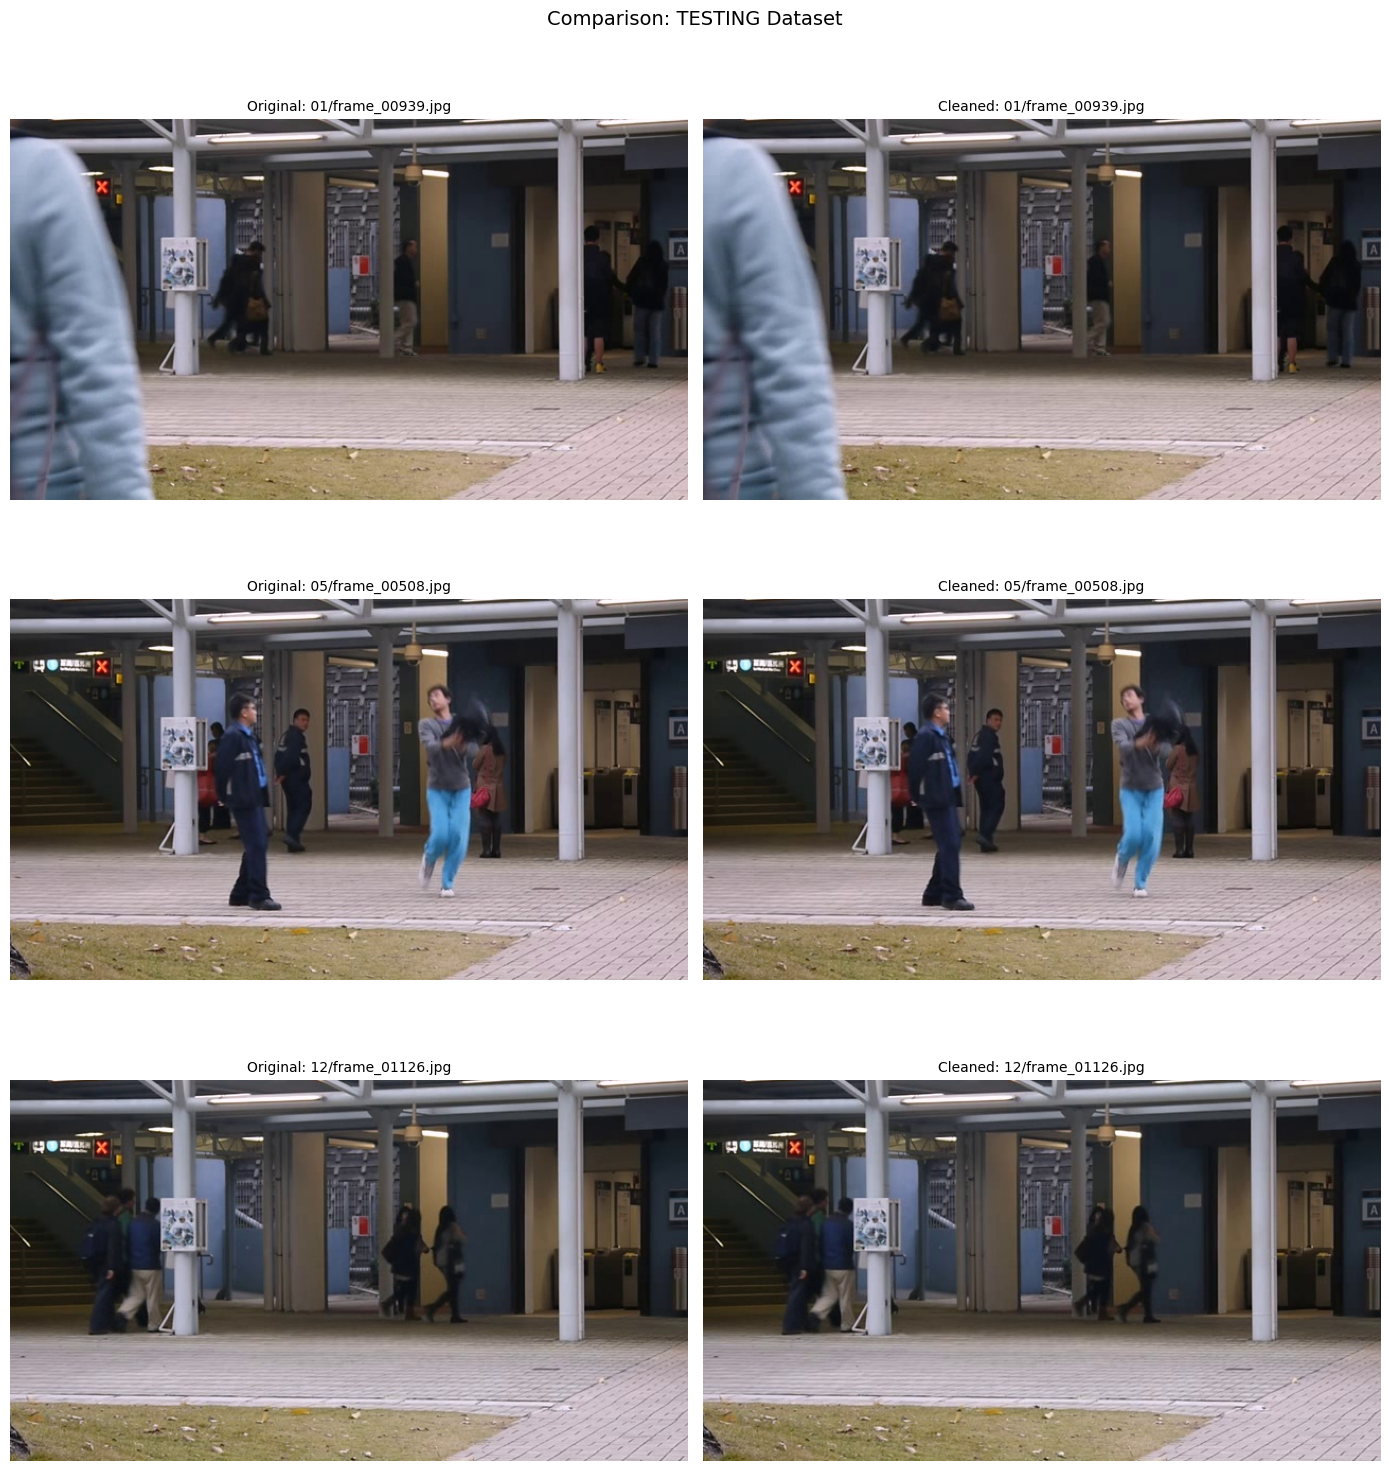

In [17]:
import matplotlib.pyplot as plt

def compare_frames(original_path, cleaned_path, num_samples=3, dataset_type='testing'):
    """
    Show side-by-side comparison of original and cleaned frames.
    
    Args:
        original_path: Path to original dataset
        cleaned_path: Path to cleaned dataset
        num_samples: Number of sample frames to show
        dataset_type: 'training' or 'testing'
    """
    folder_name = f"{dataset_type}_videos"
    frames = get_all_frame_paths(original_path, folder_name)
    
    if len(frames) == 0:
        print(f"No frames found in {folder_name} for comparison!")
        return
    
    # Sample evenly across dataset
    step = max(1, len(frames) // num_samples)
    sample_indices = [i * step for i in range(min(num_samples, len(frames)))]
    
    fig, axes = plt.subplots(len(sample_indices), 2, figsize=(14, 5*len(sample_indices)))
    
    # Handle case of single sample
    if len(sample_indices) == 1:
        axes = [axes]
    
    for idx, sample_idx in enumerate(sample_indices):
        clip_name, frame_path = frames[sample_idx]
        
        # Read original
        original = cv2.imread(str(frame_path))
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Read cleaned
        cleaned_frame_path = Path(cleaned_path) / folder_name / clip_name / frame_path.name
        if cleaned_frame_path.exists():
            cleaned = cv2.imread(str(cleaned_frame_path))
            cleaned_rgb = cv2.cvtColor(cleaned, cv2.COLOR_BGR2RGB)
        else:
            cleaned_rgb = np.zeros_like(original_rgb)
            print(f"⚠️ Cleaned frame not found: {cleaned_frame_path}")
        
        # Plot
        ax_orig, ax_clean = axes[idx]
        
        ax_orig.imshow(original_rgb)
        ax_orig.set_title(f"Original: {clip_name}/{frame_path.name}", fontsize=10)
        ax_orig.axis('off')
        
        ax_clean.imshow(cleaned_rgb)
        ax_clean.set_title(f"Cleaned: {clip_name}/{frame_path.name}", fontsize=10)
        ax_clean.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Comparison: {dataset_type.upper()} Dataset", fontsize=14, y=1.02)
    plt.show()


# Show comparison for testing dataset (where inversions are corrected)
print("📊 Showing TEST dataset comparison (inversions + blur corrected):")
compare_frames(INPUT_DATASET_PATH, OUTPUT_DATASET_PATH, num_samples=3, dataset_type='testing')


## 11. 🗑️ Cleanup (Optional)

After creating the ZIP, you can optionally remove the uncompressed cleaned dataset folder to save disk space.


In [18]:
# Set to True to remove the uncompressed folder after ZIP is created
REMOVE_UNCOMPRESSED_FOLDER = False

if REMOVE_UNCOMPRESSED_FOLDER:
    output_path = Path(OUTPUT_DATASET_PATH)
    if output_path.exists():
        print(f"🗑️ Removing uncompressed folder: {OUTPUT_DATASET_PATH}")
        shutil.rmtree(output_path)
        print(f"✅ Folder removed. ZIP file preserved.")
    else:
        print(f"Folder not found: {OUTPUT_DATASET_PATH}")
else:
    print("ℹ️ Cleanup skipped. Set REMOVE_UNCOMPRESSED_FOLDER = True to remove the folder.")


ℹ️ Cleanup skipped. Set REMOVE_UNCOMPRESSED_FOLDER = True to remove the folder.


---

## ✅ Summary

This notebook has processed your Avenue VAD dataset with the following corrections:

| Dataset | Inversion Correction | Blur/Noise Correction | Method Used |
|---------|---------------------|----------------------|-------------|
| **Training** | ❌ Disabled | ✅ Applied | OpenCV Fast NLM |
| **Testing** | ✅ Applied | ✅ Applied | Scene Geometry + OpenCV Fast NLM |

### Output Files:
- **Cleaned dataset folder**: Same structure as input with corrected frames
- **ZIP archive**: Compressed version ready for use

### Next Steps:
1. Use the cleaned dataset for training your VAD model
2. The corrections ensure AUC is not affected by image artifacts
3. Anomaly detection will now focus on actual behavioral anomalies, not image corruptions

### Methods Used:
- **Method A (Scene Geometry Analysis)**: Detects inverted frames by analyzing grass/pavement color positions
- **Method 1 (OpenCV Fast NLM)**: Denoises frames using Non-Local Means algorithm that preserves edges